In [1]:
from __future__ import print_function, division, absolute_import

import math

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy.io as sio

import dolfin as dl

from hippylib import nb

from unconstrainedMinimization import InexactNewtonCG


import logging

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

In [2]:
class Image(dl.Expression):
    def __init__(self, Lx, Ly, data, **kwargs):
        self.data = data
        self.hx = Lx/float(data.shape[1]-1)
        self.hy = Ly/float(data.shape[0]-1)
        
    def eval(self, values, x):
        j = int(math.floor(x[0]/self.hx))
        i = int(math.floor(x[1]/self.hy))
        values[0] = self.data[i,j]

In [3]:
data = sio.loadmat('circles.mat')['im']

Lx = float(data.shape[1])/float(data.shape[0])
Ly = 1.
  
mesh = dl.RectangleMesh(dl.Point(0,0),dl.Point(Lx,Ly),data.shape[1], data.shape[0])
V = dl.FunctionSpace(mesh, "Lagrange",1)

trueImage = Image(Lx,Ly,data,degree = 1)
m_true  = dl.interpolate(trueImage, V)

np.random.seed(seed=1)
noise_std_dev = .3
noise = noise_std_dev*np.random.randn(data.shape[0], data.shape[1])
noisyImage = Image(Lx,Ly,data+noise, degree = 1)
d = dl.interpolate(noisyImage, V)

# Get min/max of noisy image, so that we can show all plots in the same scale
vmin = np.min(d.vector().get_local())
vmax = np.max(d.vector().get_local())

plt.figure(figsize=(15,5))
nb.plot(m_true, subplot_loc=121, mytitle="True Image", vmin=vmin, vmax = vmax)
nb.plot(d, subplot_loc=122, mytitle="Noisy Image", vmin=vmin, vmax = vmax)
plt.show()

In [4]:
class TVDenoising:
    def __init__(self, V, d, alpha, beta):
        self.alpha   = dl.Constant(alpha)
        self.beta    = dl.Constant(beta)
        self.d       = d
        self.m_tilde  = dl.TestFunction(V)
        self.m_hat = dl.TrialFunction(V)
        
    def cost_reg(self, m):
        return dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)*dl.dx
    
    def cost_misfit(self, m):
        return dl.Constant(.5)*dl.inner(m-self.d, m - self.d)*dl.dx
        
    def cost(self, m):        
        return self.cost_misfit(m) + self.alpha*self.cost_reg(m)
        
    def grad(self, m):    
        grad_ls = dl.inner(self.m_tilde, m - self.d)*dl.dx
        
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        grad_tv = dl.Constant(1.)/TVm*dl.inner(dl.grad(m), dl.grad(self.m_tilde))*dl.dx
        
        grad = grad_ls + self.alpha*grad_tv
        
        return grad
        
    def Hessian(self,m):
        H_ls = dl.inner(self.m_tilde, self.m_hat)*dl.dx
        
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        A = dl.Constant(1.)/TVm * (dl.Identity(2) - dl.outer(dl.grad(m)/TVm, dl.grad(m)/TVm ) )
        H_tv = dl.inner(A*dl.grad(self.m_tilde), dl.grad(self.m_hat))*dl.dx
         
        H = H_ls + self.alpha*H_tv
                                   
        return H
    
    def LD_Hessian(self,m):
        H_ls = dl.inner(self.m_tilde, self.m_hat)*dl.dx
        
        TVm = dl.sqrt( dl.inner(dl.grad(m), dl.grad(m)) + self.beta)
        H_tv = dl.Constant(1.)/TVm *dl.inner(dl.grad(self.m_tilde), dl.grad(self.m_hat))*dl.dx
         
        H = H_ls + self.alpha*H_tv
                                   
        return H
            
        

In [5]:
n_eps = 32
eps = 1e-2*np.power(2., -np.arange(n_eps))
err_grad = np.zeros(n_eps)

m0 = dl.interpolate(dl.Expression("x[0]*(x[0]-1)*x[1]*(x[1]-1)", degree=4), V)
alpha = 1.
beta   = 1e-4
problem = TVDenoising(V,d,alpha, beta)

J0 = dl.assemble( problem.cost(m0) )
grad0 = dl.assemble(problem.grad(m0) )

mtilde = dl.Function(V)
mtilde.vector().set_local(np.random.randn(V.dim()))
mtilde.vector().apply("")

mtilde_grad0 = grad0.inner(mtilde.vector())

for i in range(n_eps):
    Jplus = dl.assemble( problem.cost(m0 + dl.Constant(eps[i])*mtilde) )
    err_grad[i] = abs( (Jplus - J0)/eps[i] - mtilde_grad0 )

plt.figure()    
plt.loglog(eps, err_grad, "-ob", label="Error Grad")
plt.loglog(eps, (.5*err_grad[0]/eps[0])*eps, "-.k", label="First Order")
plt.title("Finite difference check of the first variation (gradient)")
plt.xlabel("eps")
plt.ylabel("Error grad")
plt.legend(loc = "upper left")
plt.show()

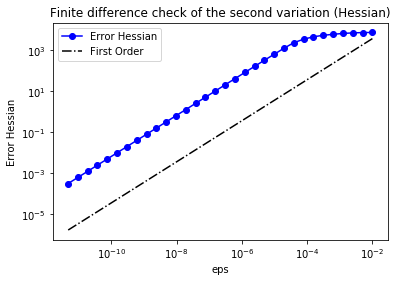

In [6]:
H_0 = dl.assemble( problem.Hessian(m0) )
H_0mtilde = H_0 * mtilde.vector()
err_H = np.zeros(n_eps)

for i in range(n_eps):
    grad_plus = dl.assemble( problem.grad(m0 + dl.Constant(eps[i])*mtilde) )
    diff_grad = (grad_plus - grad0)
    diff_grad *= 1/eps[i]
    err_H[i] = (diff_grad - H_0mtilde).norm("l2")
    
plt.figure()    
plt.loglog(eps, err_H, "-ob", label="Error Hessian")
plt.loglog(eps, (.5*err_H[0]/eps[0])*eps, "-.k", label="First Order")
plt.title("Finite difference check of the second variation (Hessian)")
plt.xlabel("eps")
plt.ylabel("Error Hessian")
plt.legend(loc = "upper left")
plt.show()


In [7]:
def TVsolution(alpha, beta):
    
    m = dl.Function(V)
    problem = TVDenoising(V, d, alpha, beta)
    
    solver = InexactNewtonCG()
    solver.parameters["rel_tolerance"] = 1e-5
    solver.parameters["abs_tolerance"] = 1e-9
    solver.parameters["gdm_tolerance"] = 1e-18
    solver.parameters["max_iter"] = 1000
    solver.parameters["c_armijo"] = 1e-5
    solver.parameters["print_level"] = -1
    solver.parameters["max_backtracking_iter"] = 10
    solver.solve(problem.cost, problem.grad, problem.Hessian, m)
    
    MSE  = dl.inner(m - m_true, m - m_true)*dl.dx
    J    = problem.cost(m)
    J_ls = problem.cost_misfit(m)
    R_tv = problem.cost_reg(m)

    print( "{0:15e} {1:15e} {2:4d} {3:15e} {4:15e} {5:15e} {6:15e}".format(
           alpha, beta, solver.it, dl.assemble(J), dl.assemble(J_ls), dl.assemble(R_tv), dl.assemble(MSE))
         )

    return m

# Part e

alpha           beta            nit  J               J_ls            R_tv            MSE            
   1.000000e-03    1.000000e+01   19    2.748766e-02    2.079902e-02    6.688631e+00    1.262773e-03
   1.000000e-03    1.000000e+00   40    2.584654e-02    2.148072e-02    4.365817e+00    9.500933e-04
   1.000000e-03    1.000000e-01   66    2.538788e-02    2.176078e-02    3.627106e+00    8.387293e-04
   1.000000e-03    1.000000e-02  147    2.526200e-02    2.185685e-02    3.405153e+00    8.064175e-04
   1.000000e-03    1.000000e-03  360    2.522709e-02    2.188693e-02    3.340160e+00    7.987682e-04
   1.000000e-03    1.000000e-04  921    2.521711e-02    2.189623e-02    3.320886e+00    7.971665e-04


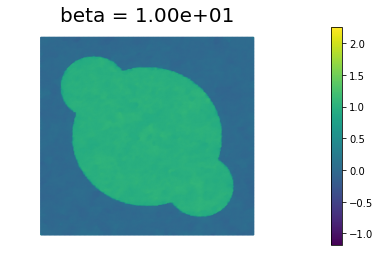

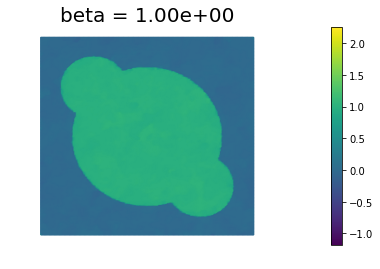

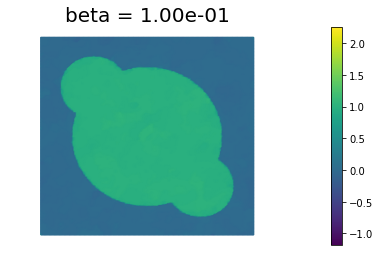

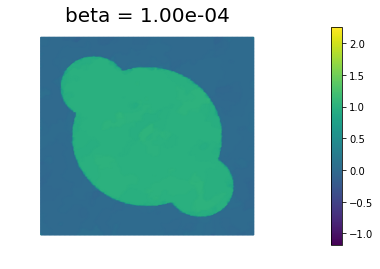

In [8]:
print ("{0:15} {1:15} {2:4} {3:15} {4:15} {5:15} {6:15}".format("alpha", "beta", "nit", "J", "J_ls", "R_tv", "MSE") )

alpha = 1e-3
betas = np.array((10.,1.,1e-1,1e-2,1e-3,1e-4))
for beta in betas:
    m = TVsolution(alpha, beta)
    plt.figure()
    nb.plot(m, vmin=vmin, vmax = vmax, mytitle="beta = {0:1.2e}".format(beta))
plt.show()

From part d, we know that for large $\beta$, the solution is more smoothed, but without preserving the edges, which corresponds to behavior similar to the Tikhinov regularization. With smaller values of $\beta$, the solution preserves the edges of image, since smoothing only occurs perpendicular to the gradient of the image. However, the cost to this is more ill-conditioning of the system.

We can see this as we go from high to low $\beta$. For high $\beta$, the number of Newton iteration is lower (less ill-conditioned), but the image edges are not as well. For low $\beta$, the number of Newton iterations is higher (more ill-conditioned), but the image edges are well preserved.

---

Copyright &copy; 2019, Washington University in St. Louis.

All Rights reserved.
See file COPYRIGHT for details.

This file is part of **cmis_labs**, the teaching material for the S2019 BME 493/593 course on *Computational Methods in Imaging Science* at Washington University in St. Louis. Please see [https://uvilla.github.io/cmis_labs](https://uvilla.github.io/cmis_labs) for more information and source code availability.

We would like to acknowledge the Extreme Science and Engineering Discovery Environment (XSEDE), which is supported by National Science Foundation grant number ACI-1548562, for providing cloud computing resources (Jetstream) for this course through allocation TG-SEE190001.